# Bank Marketing Campaign Analysis

In [47]:
#import linear algebra and data manipulation libraries
import numpy as np
import pandas as pd

#import standard visualization
import matplotlib.pyplot as plt
import seaborn as sns

# importing machine learning algorithm package
import xgboost

from sklearn.model_selection import train_test_split #split
from sklearn.metrics import accuracy_score #metrics

#tools for hyperparameters search
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

## Buisness Motivation

Analysis of organization's marketing data is one of the most typical applications of data science and machine learning.

## Data

This dataset contains banking marketing campaign data and we can use it to optimize marketing campaigns to attract more customers to term deposit subscription. A Term deposit is a deposit that a bank or a financial institurion offers with a fixed rate (often better than just opening deposit account) in which your money will be returned back at a specific maturity time.

## Attributes Description:

Input variables:

Ai. bank client data:

1 - age: (numeric)

2 - job: type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')

3 - marital: marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)

4 - education: (categorical: primary, secondary, tertiary and unknown)

5 - default: has credit in default? (categorical: 'no','yes','unknown')

6 - housing: has housing loan? (categorical: 'no','yes','unknown')

7 - loan: has personal loan? (categorical: 'no','yes','unknown')

8 - balance: Balance of the individual.


Aii. Related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')

9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')

10 - day: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')

11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.


Aiii. other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)

13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)

14 - previous: number of contacts performed before this campaign and for this client (numeric)

15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')


Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')


## Approach

In order to optimize marketing campaigns with the help of the dataset, we will have to take the following steps:
1. Import data from dataset and perform initial high-level analysis: look at the number of rows, look at the missing values, look at dataset columns and their values respective to the campaign outcome.
2. Clean the data: remove irrelevant columns, deal with missing and incorrect values, turn categorical columns into dummy variables.
3. Use machine learning techniques to predict the marketing campaign outcome and to find out factors, which affect the success of the campaign.

In [48]:
#import dataset
df = pd.read_csv('bank-full.csv')
df.head()

,"age;""job"";""marital"";""education"";""default"";""balance"";""housing"";""loan"";""contact"";""day"";""month"";""duration"";""campaign"";""pdays"";""previous"";""poutcome"";""y"""
0,"58;""management"";""married"";""tertiary"";""no"";2143..."
1,"44;""technician"";""single"";""secondary"";""no"";29;""..."
2,"33;""entrepreneur"";""married"";""secondary"";""no"";2..."
3,"47;""blue-collar"";""married"";""unknown"";""no"";1506..."
4,"33;""unknown"";""single"";""unknown"";""no"";1;""no"";""n..."


It seems that instead of ',' it was ';' which is used as delimiter

In [49]:
# Read the CSV file with semicolon as delimiter
df = pd.read_csv('bank-full.csv', delimiter=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [50]:
df = df.rename(columns={'y': 'deposit'})
# Renaming the response column to 'deposit' instead of 'y'

In [51]:
# number of rows in dataset

print("Bank marketing dataset consists of {rows} rows.".format(rows = len(df)))

Bank marketing dataset consists of 45211 rows.


In [52]:
#find percentage of missing values for each column
missing_values = df.isnull().mean()*100

missing_values.sum()

0.0

So we see that there are no missing values.

In the dataset we have both categorical and numerical columns. Let's look at the values of categorical columns first.

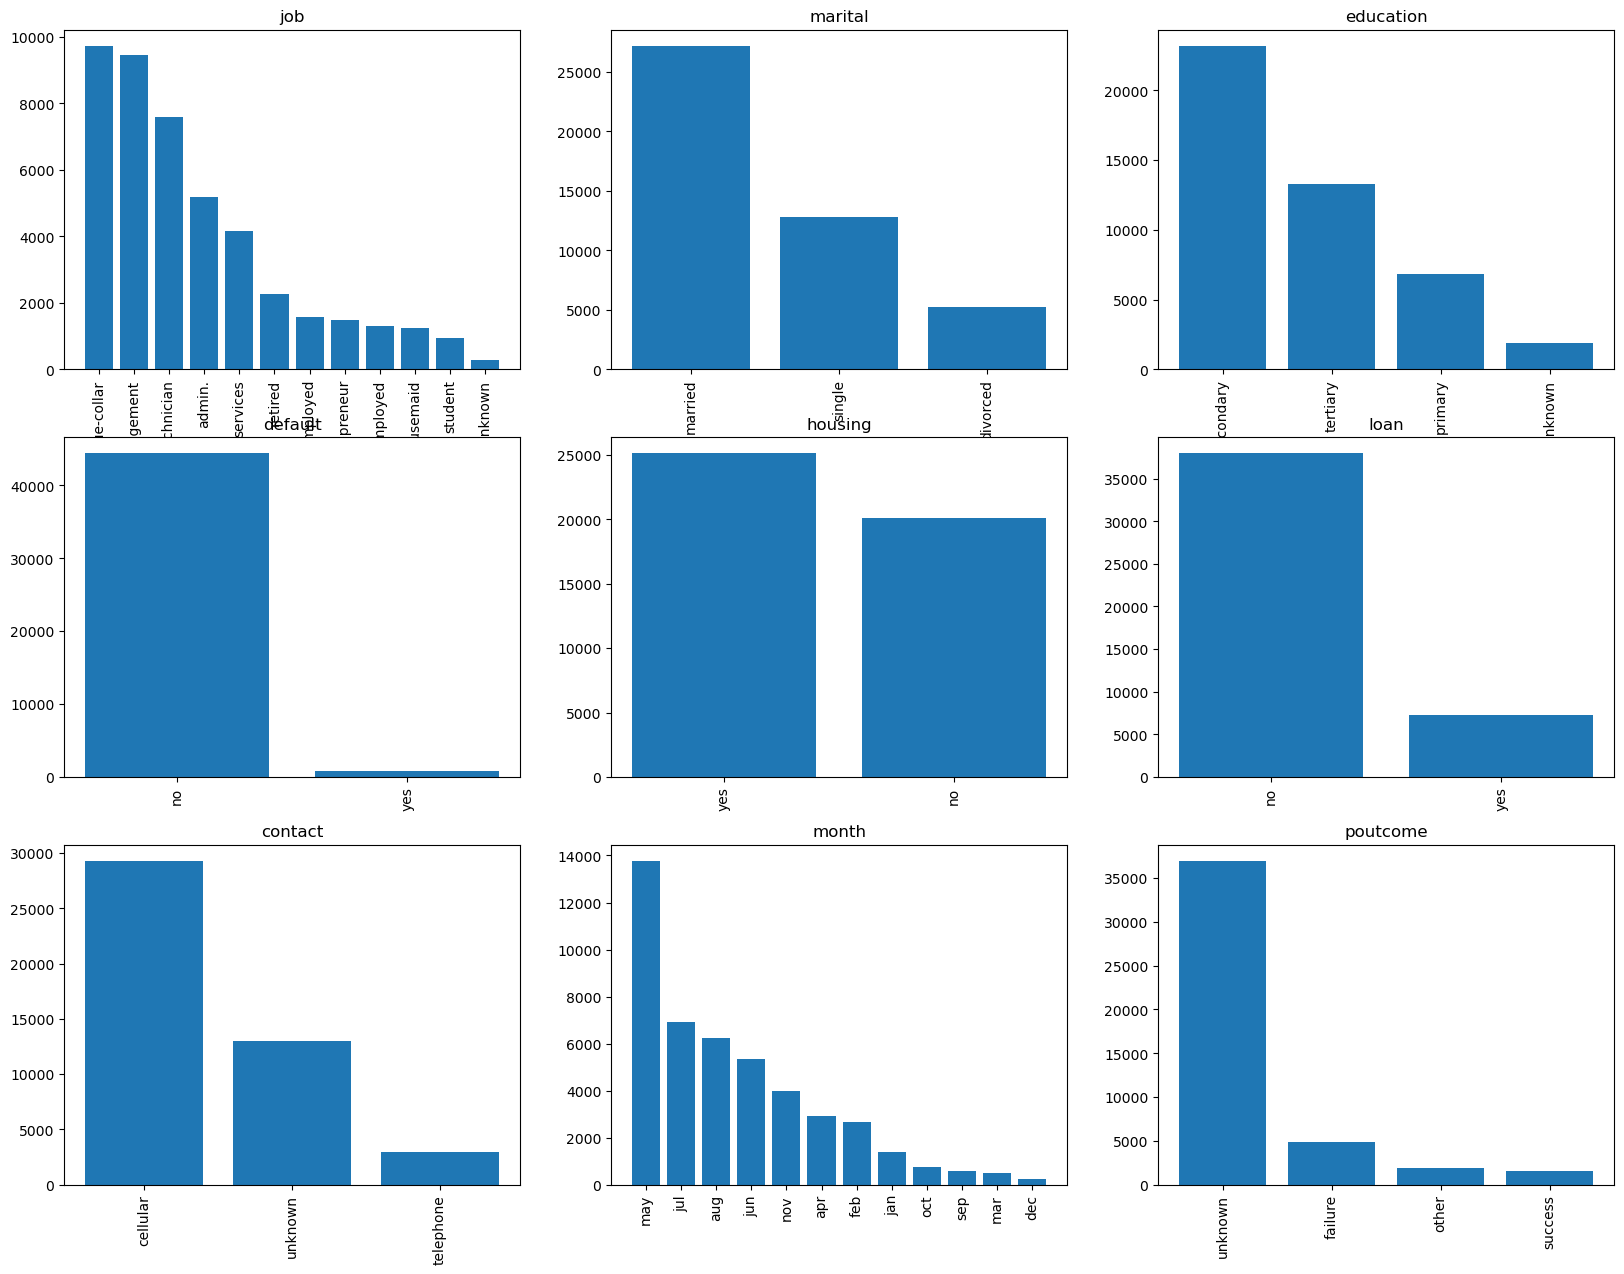

In [53]:
cat_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month','poutcome']

fig, axs = plt.subplots(3, 3, sharex=False, sharey=False, figsize=(20, 15))

counter = 0
for cat_column in cat_columns:
    value_counts = df[cat_column].value_counts()
    
    trace_x = counter // 3
    trace_y = counter % 3
    x_pos = np.arange(0, len(value_counts))
    
    axs[trace_x, trace_y].bar(x_pos, value_counts.values, tick_label = value_counts.index)
    
    axs[trace_x, trace_y].set_title(cat_column)
    
    for tick in axs[trace_x, trace_y].get_xticklabels():
        tick.set_rotation(90)
    
    counter += 1

plt.show()

Now let's look at the numerical columns' values. The most convenient way to look at the numerical values is plotting histograms.

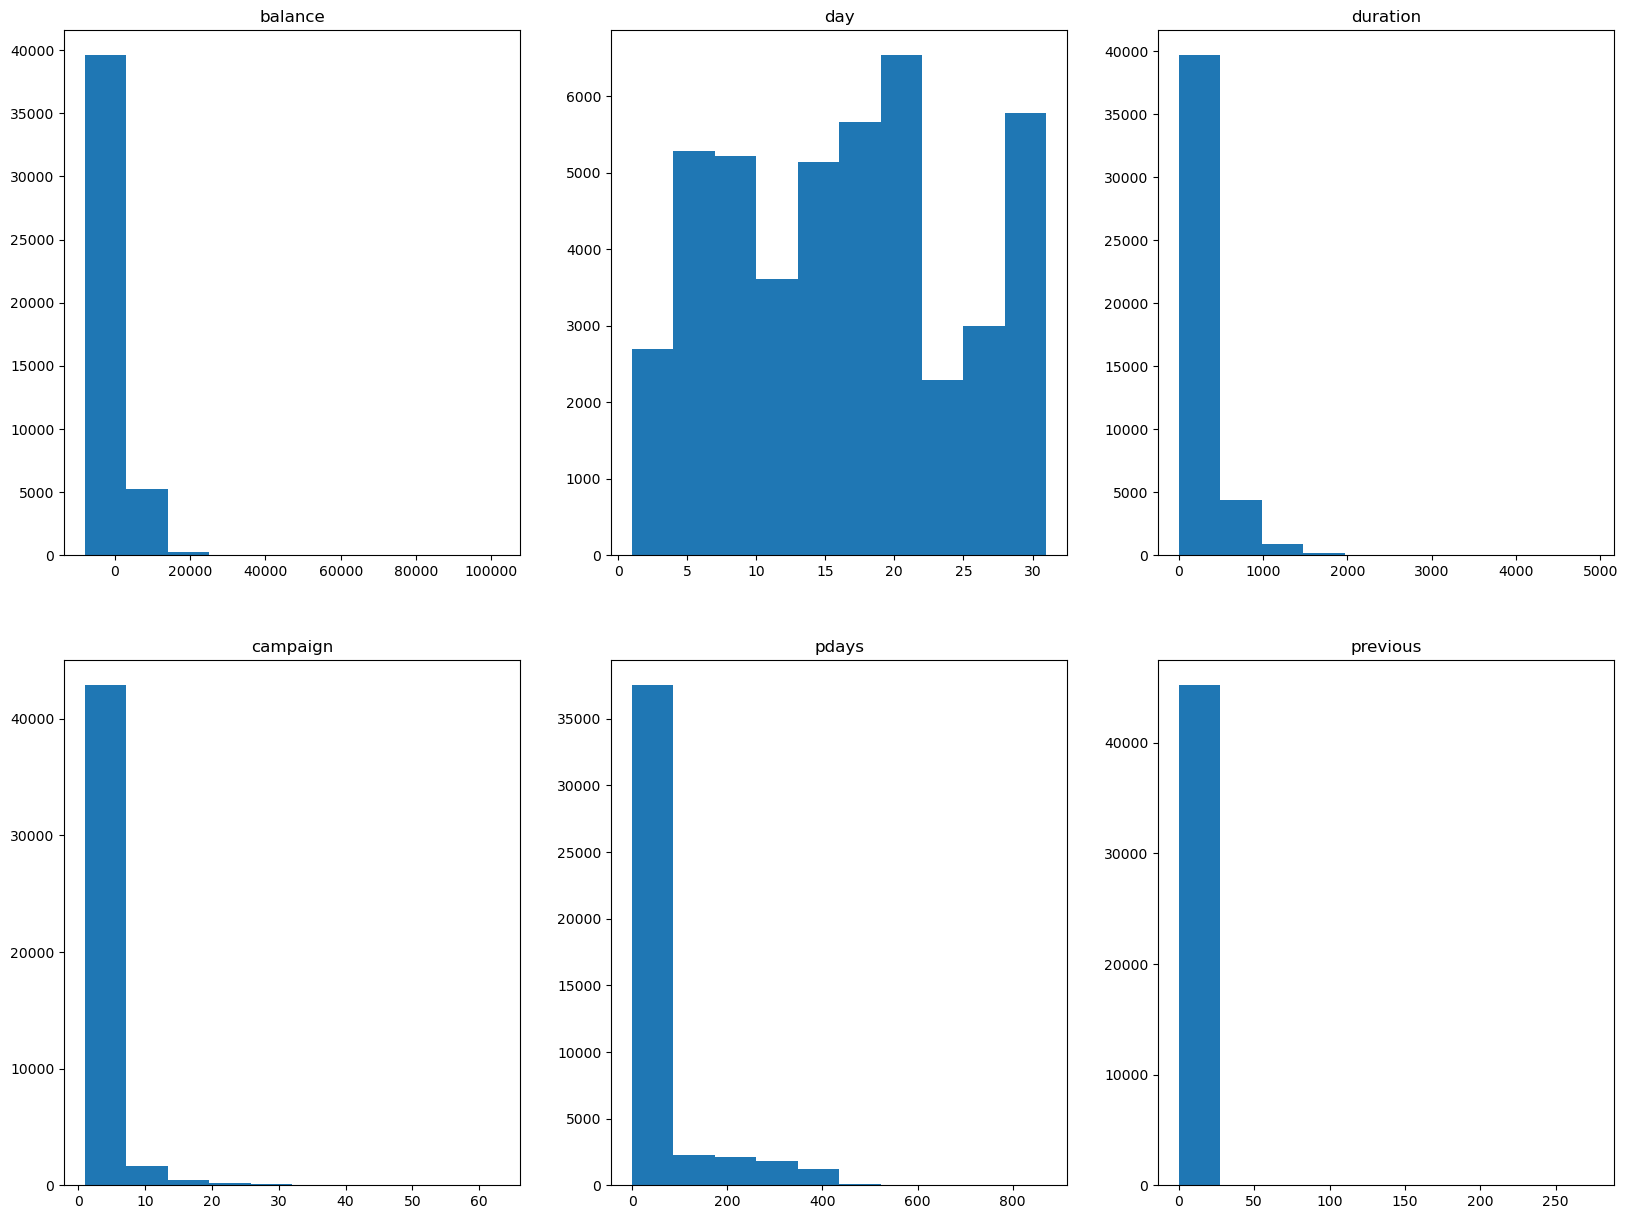

In [54]:
num_columns = ['balance', 'day','duration', 'campaign', 'pdays', 'previous']

fig, axs = plt.subplots(2, 3, sharex=False, sharey=False, figsize=(20, 15))

counter = 0
for num_column in num_columns:
    
    trace_x = counter // 3
    trace_y = counter % 3
    
    axs[trace_x, trace_y].hist(df[num_column])
    
    axs[trace_x, trace_y].set_title(num_column)
    
    counter += 1

plt.show()

We can see that numerical columns have outliers (especially 'pdays', 'campaign' and 'previous' columns). Possibly there are incorrect values (noisy data), so we should look closer at the data and decide how do we manage the noise.
<br> Let's look closer at the values of 'campaign', 'pdays' and 'previous' columns:

In [55]:
df[['pdays', 'campaign', 'previous']].describe()

,pdays,campaign,previous
count,45211.000000,45211.000000,45211.000000
mean,40.197828,2.763841,0.580323
std,100.128746,3.098021,2.303441
min,-1.000000,1.000000,0.000000
25%,-1.000000,1.000000,0.000000
50%,-1.000000,2.000000,0.000000
75%,-1.000000,3.000000,0.000000
max,871.000000,63.000000,275.000000


In [56]:
# Percentage of 'pdays' values above 400:
len (df[df['pdays'] > 400] ) / len(df) * 100

0.5175731569750724

In [57]:
a = len(df[df['pdays'] == -1])
print ("People that were never contacted earlier: ", a)
print()
print('Percentage datapoint having -1 value in pdays: ', (a/len(df))*100)

People that were never contacted earlier:  36954

Percentage datapoint having -1 value in pdays:  81.73674548229414


'pdays' holds the number of days that passed by after the client was last contacted from a previous campaign
Looking closer into 'pdays' data we can see that:
* only 0.52% of values above 400. They are possibly outliers, so we should consider imputing something (possibly mean value) instead of these values.
* -1 means that the client wasn't contacted before or stands for missing data.

I suggest to drop this column, because -1 makes nearly 90% of the values of the column.

In [58]:
len (df[df['campaign'] > 34] ) / len(df) * 100

0.059719979650969895

'campaign' holds the number of contacts performed during this campaign and for this client (numeric, includes last contact)
Numbers for 'campaign' above 34 are clearly noise, so I suggest to impute them with average campaign values while data cleaning.

Percentage of 'previous' values above 20:

In [59]:
len (df[df['previous'] > 34] ) / len(df) * 100

0.024330362080024773

'previous' holds the number of contacts performed before this campaign and for this client (numeric)
Numbers for 'previous' above 34 are also really strange, so I suggest to impute them with average campaign values while data cleaning.

### Analysis of the response column

It is very important to look at the response column, which holds the information, which we are going to predict. In our case we should look at 'deposit' column and compare its values to other columns. 
<br> First of all we should look at the number of 'yes' and 'no' values in the response column 'deposit'.

<Axes: title={'center': 'Deposit value counts'}, xlabel='deposit'>

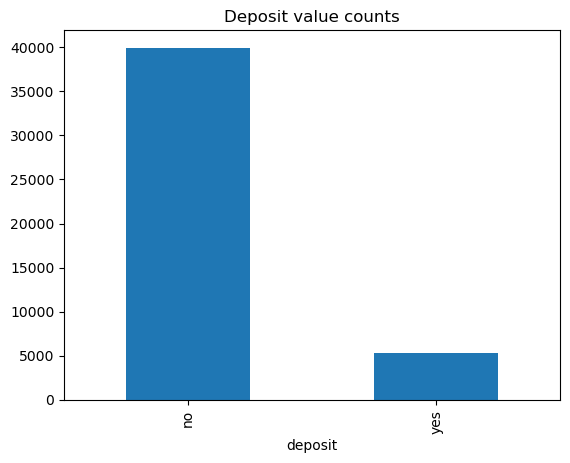

In [60]:
value_counts = df['deposit'].value_counts()

value_counts.plot.bar(title = 'Deposit value counts')

In [61]:
n_no = value_counts[0]
n_yes = value_counts[1]
print("percentage of No: ", (n_no/(n_no+n_yes))*100)


percentage of No:  88.30151954170445


In [62]:
value_counts

deposit
no     39922
yes     5289
Name: count, dtype: int64

This is severely imbalnced dataset, where 'NO' is 88%. I suggest undersampling of Majority Class, but before that we should drop duplicates.

In [63]:
df = df.drop_duplicates()
value_counts = df['deposit'].value_counts()
value_counts

deposit
no     39922
yes     5289
Name: count, dtype: int64

Actually, it seems that there are no duplicate entries in the dataset. Lets go ahead with undersampling of Majority class.

I have decided to go for same number of samples for No as it is there for Yes.

In [64]:
from sklearn.utils import shuffle

# Separate the data by class
no_class = df[df['deposit'] == 'no']
yes_class = df[df['deposit'] == 'yes']

# Randomly sample 5289 instances from the 'No' class
no_class_undersampled = no_class.sample(n=5289, random_state=42)

# Concatenate the undersampled 'No' class with the 'Yes' class
undersampled_data = pd.concat([no_class_undersampled, yes_class], axis=0)

# Use shuffle on resulting dataset to mix the rows and ensure that the data is well randomized.
df = shuffle(undersampled_data, random_state=42)
# Also, overwriting it on the original dataframe

# Check the new class distribution
print(df['deposit'].value_counts())


deposit
yes    5289
no     5289
Name: count, dtype: int64


In [65]:
df = df.reset_index(drop= True)

In [66]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,39,management,divorced,tertiary,no,517,yes,yes,unknown,14,may,1328,1,-1,0,unknown,yes
1,30,services,married,secondary,no,3929,yes,no,cellular,20,nov,593,1,-1,0,unknown,yes
2,46,management,divorced,tertiary,no,624,no,no,cellular,18,mar,420,1,276,1,other,yes
3,32,admin.,married,tertiary,no,653,no,no,cellular,2,jun,84,1,-1,0,unknown,yes
4,36,blue-collar,married,primary,no,319,yes,no,cellular,13,may,774,2,301,1,failure,yes


Since, we have balanced dataset now, we can use accuracy as a metric for a model, which predicts the campaign outcome.

Let's see how 'deposit' column value varies depending on other categorical columns' values:

<Axes: title={'center': 'Job and deposit'}, xlabel='job'>

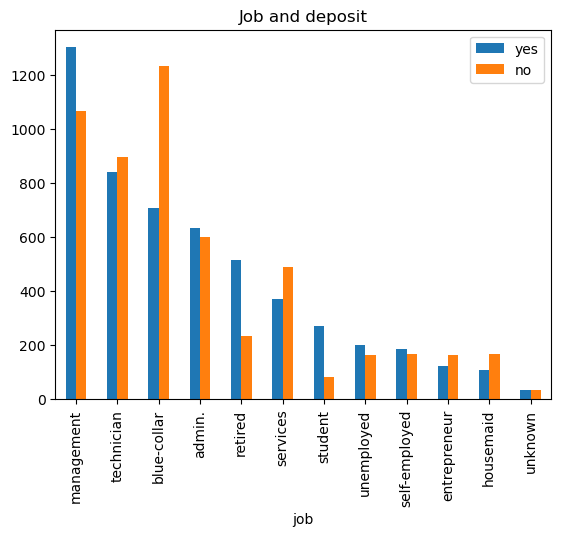

In [67]:
#job and deposit
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['job'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['job'].value_counts()

j_df.plot.bar(title = 'Job and deposit')

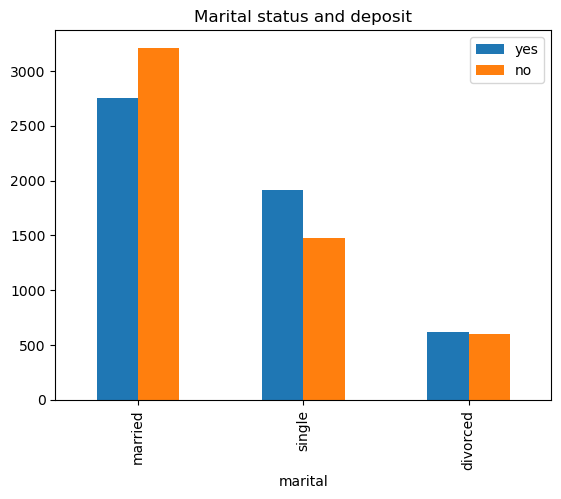

In [68]:
#marital status and deposit
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['marital'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['marital'].value_counts()

j_df.plot.bar(title = 'Marital status and deposit')
plt.show();

<Axes: title={'center': 'Education and deposit'}, xlabel='education'>

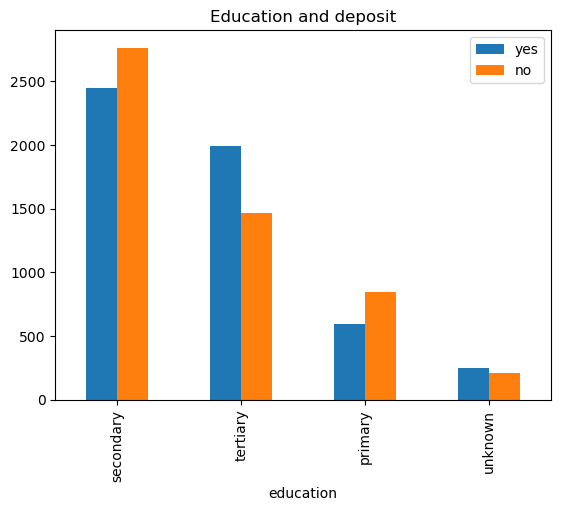

In [69]:
#education and deposit
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['education'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['education'].value_counts()

j_df.plot.bar(title = 'Education and deposit')

<Axes: title={'center': 'Type of contact and deposit'}, xlabel='contact'>

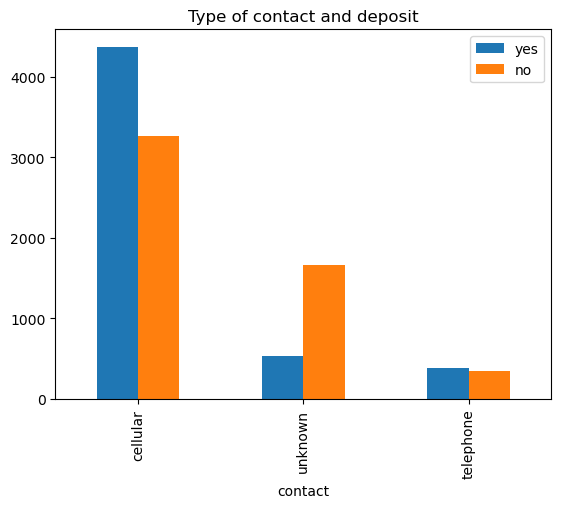

In [70]:
#type of contact and deposit
j_df = pd.DataFrame()

j_df['yes'] = df[df['deposit'] == 'yes']['contact'].value_counts()
j_df['no'] = df[df['deposit'] == 'no']['contact'].value_counts()

j_df.plot.bar(title = 'Type of contact and deposit')

Regarding the diagrams we can tell that according to our dataset:
1. Customers with 'blue-collar' and 'services' jobs are less likely to subscribe for term deposit.
2. Married customers are less likely to subscribe for term deposit.
3. Customers with 'cellular' type of contact are more likely to subscribe for term deposit.

Now let's look how numerical columns affect term deposit subscription.

In [71]:
#balance and deposit

b_df = pd.DataFrame()
b_df['balance_yes'] = (df[df['deposit'] == 'yes'][['deposit','balance']].describe())['balance']
b_df['balance_no'] = (df[df['deposit'] == 'no'][['deposit','balance']].describe())['balance']

b_df

,balance_yes,balance_no
count,5289.000000,5289.000000
mean,1804.267915,1252.418794
std,3501.104777,2668.246832
min,-3058.000000,-2093.000000
25%,210.000000,55.000000
50%,733.000000,416.000000
75%,2159.000000,1301.000000
max,81204.000000,52527.000000


<Axes: title={'center': 'Balance and deposit statistics'}>

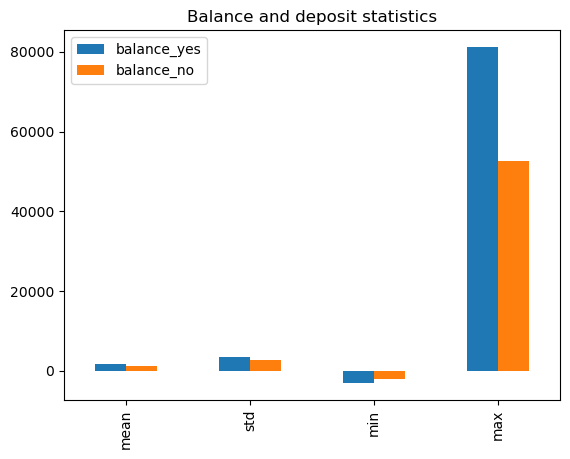

In [72]:
b_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Balance and deposit statistics')

In [73]:
#age and deposit

a_df = pd.DataFrame()
a_df['age_yes'] = (df[df['deposit'] == 'yes'][['deposit','age']].describe())['age']
a_df['age_no'] = (df[df['deposit'] == 'no'][['deposit','age']].describe())['age']

a_df

,age_yes,age_no
count,5289.000000,5289.000000
mean,41.670070,40.708641
std,13.497781,10.281919
min,18.000000,19.000000
25%,31.000000,33.000000
50%,38.000000,39.000000
75%,50.000000,48.000000
max,95.000000,89.000000


<Axes: title={'center': 'Age and deposit statistics'}>

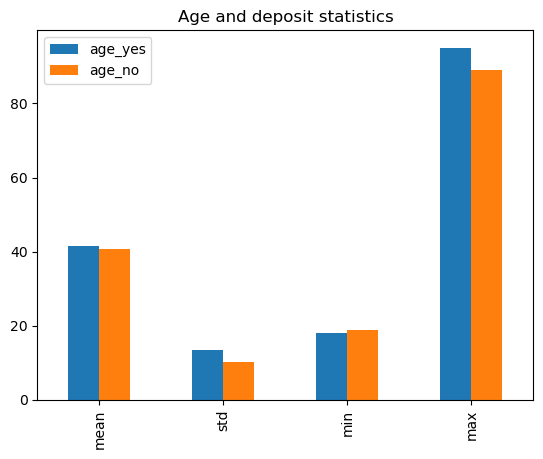

In [74]:
a_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Age and deposit statistics')

In [75]:
#number of contacts performed during this campaign ('campaign') and deposit
c_df = pd.DataFrame()
c_df['campaign_yes'] = (df[df['deposit'] == 'yes'][['deposit','campaign']].describe())['campaign']
c_df['campaign_no'] = (df[df['deposit'] == 'no'][['deposit','campaign']].describe())['campaign']

c_df

,campaign_yes,campaign_no
count,5289.000000,5289.000000
mean,2.141047,2.846663
std,1.921826,3.178462
min,1.000000,1.000000
25%,1.000000,1.000000
50%,2.000000,2.000000
75%,3.000000,3.000000
max,32.000000,63.000000


<Axes: title={'center': 'Number of contacts performed during this campaign and deposit statistics'}>

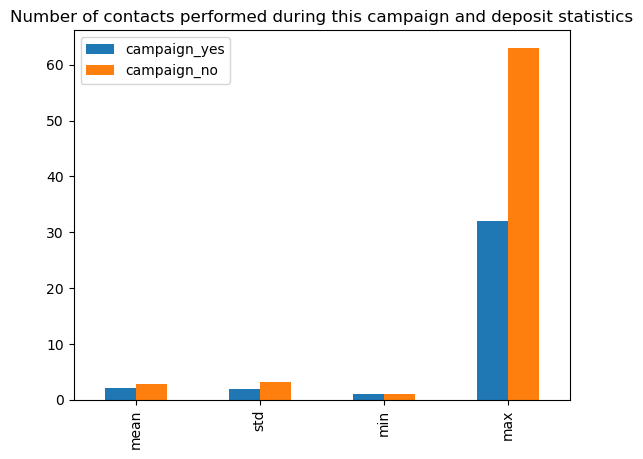

In [76]:
c_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Number of contacts performed during this campaign and deposit statistics')

In [77]:
#number of contacts performed during previous campaign ('previous') and deposit
p_df = pd.DataFrame()
p_df['previous_yes'] = (df[df['deposit'] == 'yes'][['deposit','previous']].describe())['previous']
p_df['previous_no'] = (df[df['deposit'] == 'no'][['deposit','previous']].describe())['previous']

p_df

,previous_yes,previous_no
count,5289.000000,5289.000000
mean,1.170354,0.550766
std,2.553272,4.274892
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,1.000000,0.000000
max,58.000000,275.000000


<Axes: title={'center': 'Number of contacts performed during previous campaign and deposit statistics'}>

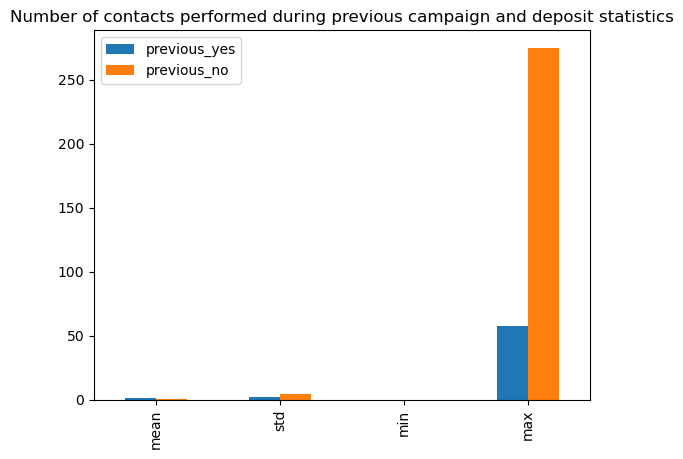

In [78]:
p_df.drop(['count', '25%', '50%', '75%']).plot.bar(title = 'Number of contacts performed during previous campaign and deposit statistics')

Looking at the diagrams above we can conclude that:
1. People who subscribed for term deposit tend to have greater balance and age values.
2. People who subscribed for term deposit tend to have fewer number of contacts during this campaign.

## Data Cleaning

Before we will be able to apply machine learning techniques, we should prepare the dataset for processing:
1. Convert columns with 'yes' and 'no' values to boolean columns;
2. Convert categorical columns into dummy variables.

In [79]:
def get_dummy_from_bool(row, column_name):
    ''' Returns 0 if value in column_name is no, returns 1 if value in column_name is yes'''
    return 1 if row[column_name] == 'yes' else 0

def get_correct_values(row, column_name, threshold, df):
    ''' Returns mean value if value in column_name is above threshold'''
    if row[column_name] <= threshold:
        return row[column_name]
    else:
        mean = df[df[column_name] <= threshold][column_name].mean()
        return mean

def clean_data(df):
    '''
    INPUT
    df - pandas dataframe containing bank marketing campaign dataset
    
    OUTPUT
    df - cleaned dataset:
    1. columns with 'yes' and 'no' values are converted into boolean variables;
    2. categorical columns are converted into dummy variables;
    3. drop irrelevant columns.
    4. impute incorrect values
    '''
    
    cleaned_df = df.copy()
    
    #convert columns containing 'yes' and 'no' values to boolean variables and drop original columns
    bool_columns = ['default', 'housing', 'loan', 'deposit']
    for bool_col in bool_columns:
        cleaned_df[bool_col + '_bool'] = df.apply(lambda row: get_dummy_from_bool(row, bool_col),axis=1)
    
    cleaned_df = cleaned_df.drop(columns = bool_columns)
    
    #convert categorical columns to dummies
    cat_columns = ['job', 'marital', 'education', 'contact', 'month', 'poutcome']
    
    for col in  cat_columns:
        cleaned_df = pd.concat([cleaned_df.drop(col, axis=1),
                                pd.get_dummies(cleaned_df[col], prefix=col, prefix_sep='_',
                                               drop_first=True, dummy_na=False)], axis=1)
    
    #drop irrelevant columns
    cleaned_df = cleaned_df.drop(columns = ['pdays'])
    
    #impute incorrect values and drop original columns
    cleaned_df['campaign_cleaned'] = df.apply(lambda row: get_correct_values(row, 'campaign', 34, cleaned_df),axis=1)
    cleaned_df['previous_cleaned'] = df.apply(lambda row: get_correct_values(row, 'previous', 34, cleaned_df),axis=1)
    
    cleaned_df = cleaned_df.drop(columns = ['campaign', 'previous'])
    
    return cleaned_df

In [80]:
#clean the dataset
cleaned_df = clean_data(df)
cleaned_df.head()

,age,balance,day,duration,default_bool,housing_bool,loan_bool,deposit_bool,job_blue-collar,job_entrepreneur,...,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_other,poutcome_success,poutcome_unknown,campaign_cleaned,previous_cleaned
0,39,517,14,1328,0,1,1,1,False,False,...,False,True,False,False,False,False,False,True,1.0,0.0
1,30,3929,20,593,0,1,0,1,False,False,...,False,False,True,False,False,False,False,True,1.0,0.0
2,46,624,18,420,0,0,0,1,False,False,...,True,False,False,False,False,True,False,False,1.0,1.0
3,32,653,2,84,0,0,0,1,False,False,...,False,False,False,False,False,False,False,True,1.0,0.0
4,36,319,13,774,0,1,0,1,True,False,...,False,True,False,False,False,False,False,False,2.0,1.0


## Machine Learning for prediction of campaign outcome

### Classification model for the campaign outcome prediction

Now let's use cleaned datasets for prediction of campaign outcome with help of machine learning classification models. I will use __[XGBoost](https://xgboost.readthedocs.io/en/latest/)__, which is one of the most common machine learning libraries for modelling.
<br> Resulting model will also help me to understand, which features have the greatest importance for the prediction of the results of the campaing.

Create X and y datasets for training the model and split into train and test datasets.

In [81]:
X = cleaned_df.drop(columns = 'deposit_bool')
y = cleaned_df[['deposit_bool']]

In [82]:
TEST_SIZE = 0.3
RAND_STATE = 42

In [83]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state=RAND_STATE)

Train XGBoost classifier model:

In [84]:
#train XGBoost model
xgb = xgboost.XGBClassifier(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.75,
                           colsample_bytree=1, max_depth=7)
xgb.fit(X_train,y_train.squeeze().values)

#calculate and print scores for the model for top 15 features
y_train_preds = xgb.predict(X_train)
y_test_preds = xgb.predict(X_test)

print('XGB accuracy score for train: %.3f: test: %.3f' % (
        accuracy_score(y_train, y_train_preds),
        accuracy_score(y_test, y_test_preds)))

XGB accuracy score for train: 0.915: test: 0.862


Get the feature importances from the trained model:

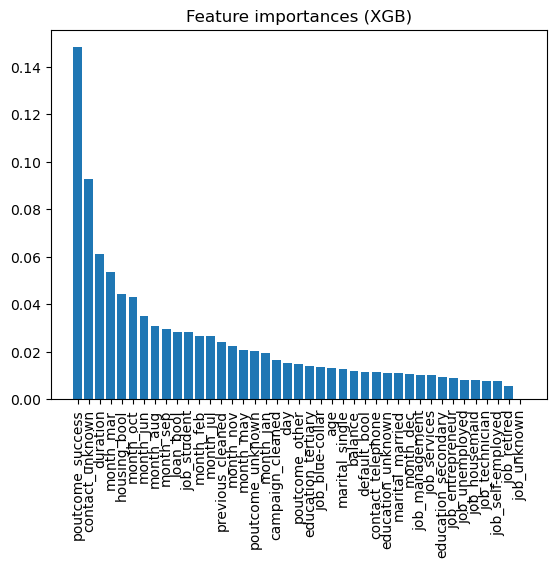

In [85]:
#get feature importances from the model
headers = ["name", "score"]
values = sorted(zip(X_train.columns, xgb.feature_importances_), key=lambda x: x[1] * -1)
xgb_feature_importances = pd.DataFrame(values, columns = headers)

#plot feature importances
x_pos = np.arange(0, len(xgb_feature_importances))
plt.bar(x_pos, xgb_feature_importances['score'])
plt.xticks(x_pos, xgb_feature_importances['name'])
plt.xticks(rotation=90)
plt.title('Feature importances (XGB)')

plt.show()

As we can see from the diagram showing feature importances, the most important features are:
* Customer's account balance,
* Customer's age,
* Number of contacts performed during this campaign and contact duration,
* Number of contacts performed before this campaign.

So the main outcomes of the modelling are:
* Customers of greater age are more likely to subscribe for the term deposit.
* Customers with greater account balance are more likely to subscribe for the term deposit.
* Number of contacts with the customers really matters. Too many contacts with the customer could make him decline the offer.

Let's try to make more specific recommendations:

1. Find out account balance, which marketing campaign should focus on: 

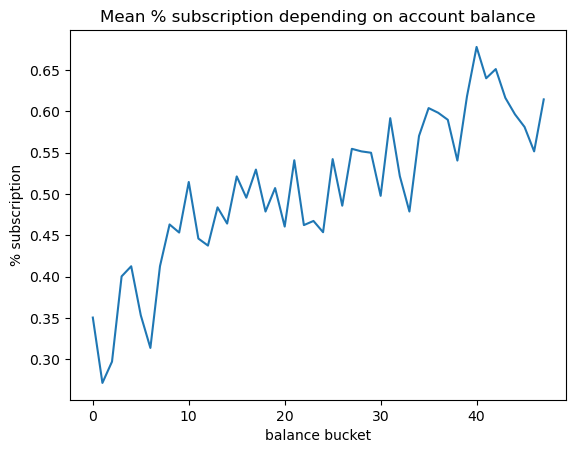

In [86]:
df_new = cleaned_df.copy()

#introduce new column 'balance_buckets' to  ''
df_new['balance_buckets'] = pd.qcut(df_new['balance'], 50, labels=False, duplicates = 'drop')

#group by 'balance_buckets' and find average campaign outcome per balance bucket
mean_deposit = df_new.groupby(['balance_buckets'])['deposit_bool'].mean()

#plot
plt.plot(mean_deposit.index, mean_deposit.values)
plt.title('Mean % subscription depending on account balance')
plt.xlabel('balance bucket')
plt.ylabel('% subscription')
plt.show()

In [87]:
df_new[df_new['balance_buckets'] == 34]['balance'].min()

1485

From the diagram above we can conclude, that marketing campaigns should concentrate on customers with account balance greater than 1490$.

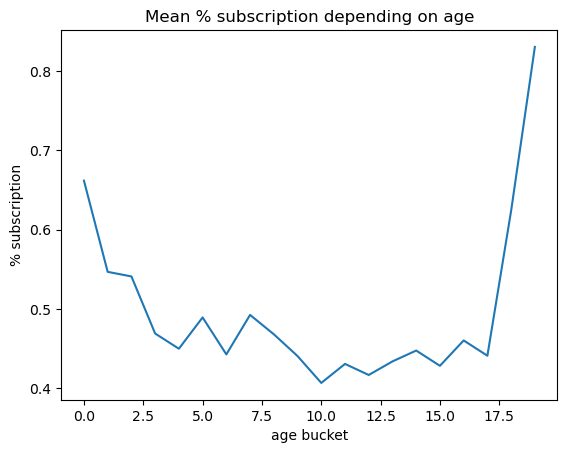

In [88]:
#introduce new column 'age_buckets' to  ''
df_new['age_buckets'] = pd.qcut(df_new['age'], 20, labels=False, duplicates = 'drop')

#group by 'balance_buckets' and find average campaign outcome per balance bucket
mean_age = df_new.groupby(['age_buckets'])['deposit_bool'].mean()

#plot
plt.plot(mean_age.index, mean_age.values)
plt.title('Mean % subscription depending on age')
plt.xlabel('age bucket')
plt.ylabel('% subscription')
plt.show()

In [89]:
df_new[df_new['age_buckets'] == 3]['age'].max()

31

In [90]:
df_new[df_new['age_buckets'] == 17]['age'].min()

56

So we see that average subscrition rate tends to be higher for customers below 31 years old or above 56 years old.

3. Find out appropriate number of contacts with the customer during campaign:

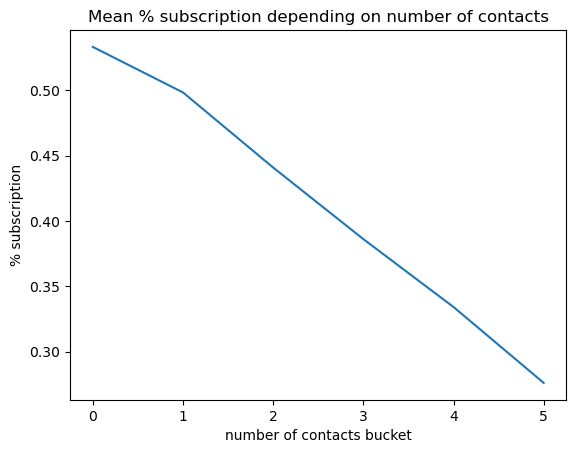

In [91]:
#introduce new column 'age_buckets' to  ''
df_new['campaign_buckets'] = pd.qcut(df_new['campaign_cleaned'], 20, labels=False, duplicates = 'drop')

#group by 'balance_buckets' and find average campaign outcome per balance bucket
mean_campaign = df_new.groupby(['campaign_buckets'])['deposit_bool'].mean()

#plot average campaign outcome per bucket 
plt.plot(mean_campaign.index, mean_campaign.values)
plt.title('Mean % subscription depending on number of contacts')
plt.xlabel('number of contacts bucket')
plt.ylabel('% subscription')
plt.show()

In [92]:
df_new[df_new['campaign_buckets'] == 2]['campaign_cleaned'].min()

4.0

From the plot above we see that average subscription rate is below 50% if the number of contacts during the campaign exceeds 4.

## Conclusion

Key outcomes of the analysis are the recommendations for future marketing campaigns:
* The customer's account balance has a huge influence on the campaign's outcome. People with account balance above 1490$ are more likely to subscribe for term deposit, so future address those customers.
* The customer's age affects campaign outcome as well. Future campains should concentrate on customers from age categories below 30 years old and above 50 years old.
* Number of contacts with the customer during the campaign is also very important. The number of contacts with the customer shouldn't exceed 4.